In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.nn.modules import dropout
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import torch.nn.functional as F
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

In [57]:
train_df=pd.read_csv("/Users/srishtysuman/PycharmProjects/NaturalLanguageProcessing/sentiment_analysis_data/train.csv", encoding='latin1')
test_df=pd.read_csv("/Users/srishtysuman/PycharmProjects/NaturalLanguageProcessing/sentiment_analysis_data/test.csv", encoding='latin1')

# 1. get only relevant columns as train_df and test_df
train_df=train_df[['text', 'sentiment']].dropna()
test_df=test_df[['text', 'sentiment']].dropna()

# 2. for sentiment, give binary labels
def binary_labels(label):
    if label=="positive":
        return 2
    elif label=="neutral":
        return 1
    else:
        return 0
train_df["sentiment"]=train_df["sentiment"].apply(binary_labels)
test_df["sentiment"]=test_df["sentiment"].apply(binary_labels)
test_df

def clean_text(text):
    if type(text)!=str or pd.isnull(text) or text=='':
        return ''
    text=text.lower()   
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    text=re.sub(link_re_pattern, '', text)
    text=re.sub("\`have", 'have', text)   
    text=re.sub("\`ve", ' have', text)   
    text = text.lower()
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r'\d+', '',text)
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)
    text = text.replace("?","")
    text = text.replace("(","")
    text = text.replace(")","")
    text = text.replace('"',"")
    text = text.replace(",","")
    text = text.replace("#","")   
    text = text.replace("-","")    
    text = text.replace("..","")
    text = text.replace("/","")
    text = text.replace("\\","")
    text = text.replace(":","")
    text = text.replace("the","") 
    text=re.sub(r'[^\w\s]','',text)
    text=re.sub("(.)\\1{2,}", "\\1", text)
    text=re.sub("ii", "i", text)
    text=re.sub("_", "", text)
    text=re.sub("^http", "", text) 
    return text    
    
train_df["text"]=train_df["text"].apply(clean_text)
test_df["text"]=test_df["text"].apply(clean_text)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

def tokenize(df, test_df):
    word_to_index=dict()
    index_to_word=['<unk>']
    stopword=stopwords.words('english')
    count=0
    tokenize_column=[]
    for index, row in df.iterrows():
        text=row["text"]
        words=[word for word in text.split()]
        token_list=[]
        for word in words:
            if word in stopword:
                continue
            if word not in word_to_index:
                count+=1
                word_to_index[word]=count
                index_to_word.append(count)
            token_list.append(word_to_index[word])
        tokenize_column.append(token_list)
    df["text_map"]=tokenize_column

    tokenize_column=[]
    for index, row in test_df.iterrows():
        text=row["text"]
        words=[word for word in text.split()]
        token_list=[]
        for word in words:
            if word in stopword:
                continue
            if word not in word_to_index:
                token_list.append(0)
            else:
                token_list.append(word_to_index[word])
        tokenize_column.append(token_list)
    test_df["text_map"]=tokenize_column    
    return df, test_df, word_to_index, index_to_word

train_df, test_df, word_to_index, index_to_word = tokenize(train_df, test_df)

test_df = test_df[test_df['text_map'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
train_df = train_df[train_df['text_map'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

class TextDataloader(Dataset):
    def __init__(self, text_list, text_map, labels):
        """
        Params:
        -------
        test : list
               list with tuples of all the texts
        
        word2index : dict
                     vocbulary of the dataset
        labels : list 
                 list of the corrsponding labels to the question pairs 
        
        """
        self.text_list = text_list
        self.text_map = text_map
        self.labels = labels
        
    def __len__(self):
        return len(self.text_list)
    
    def __getitem__(self, index):
        text_map = self.text_map[index]
        text = self.text_list[index]
        text="".join(word for word in text)
            
        # q1_indices and q2_indices are lists of indices against words used in the sentence 
        return {
            'text': text,
            'text_map': text_map, 
            'labels': self.labels[index], 
        }
    
def data_to_tuple(df):
    text=df["text"].tolist()
    text_map=df["text_map"].tolist()
    labels=df["sentiment"].tolist()
    return text, text_map, labels

train_text, train_text_map, train_labels=data_to_tuple(train_df)
test_text, test_text_map, test_labels=data_to_tuple(test_df)

train_dataset=TextDataloader(train_text, train_text_map, train_labels)
test_dataset=TextDataloader(test_text, test_text_map, test_labels)

print(len(test_dataset))
for sample in test_dataset:
    print(sample["text"])
    print(sample["text_map"])
    print(sample["labels"])   
    break

def collate_fn(batch):
    text = []
    text_map = []
    labels = []
    for item in batch:
        text.append(item['text'])
        text_map.append(item['text_map'])
        labels.append(item['labels'])
          
        
    text_lengths = [len(q) for q in text_map]

    sorted_indices=np.flipud(np.argsort(text_lengths))
    lengths=np.flipud(np.sort(text_lengths))
    lengths = lengths.copy()

    sorted_text = [text[i] for i in sorted_indices]
    sorted_texts_map = [torch.LongTensor(text_map[i]).to('cpu') for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]

    sorted_texts_map = pad_sequence(sorted_texts_map, batch_first=True)    

    return {
        'text': sorted_text,
        'text_map': sorted_texts_map, 
        'text_lengths': lengths,
        'labels': sorted_labels
    }

train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=512, collate_fn=collate_fn)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=512, collate_fn=collate_fn)

embedding_dim=300
embeddings=torch.randn(len(index_to_word), 300)
embeddings[0] = torch.zeros(embedding_dim)



3522
last session of  day  httptwitpiccomezh
[228, 3303, 229, 0]
1


In [87]:
class EmbeddingLSTMNet(nn.Module):
    def __init__(self, embedding_dim, hidden_cells, num_layers, embedding_grad, embeddings, dropout, num_classes):
        super(EmbeddingLSTMNet, self).__init__()
        self.device='cpu'
        self.embedding=nn.Embedding.from_pretrained(embeddings)
        self.embedding.weight.requires_grad=embedding_grad
        self.dropout=nn.Dropout(dropout)

        self.lstm=nn.LSTM(input_size=embedding_dim, hidden_size=hidden_cells, num_layers=num_layers, batch_first=True)
        self.fc1=nn.Linear(hidden_cells, hidden_cells)
        self.relu1=nn.ReLU()      
        self.batch_norm1=nn.BatchNorm1d(hidden_cells)

        self.fc2=nn.Linear(hidden_cells, num_classes)        
        self.final_softmax=nn.Softmax()
        self.final_layer=nn.Sigmoid()

        self.hidden_cells=hidden_cells

    
    def forward(self, texts, texts_map, lengths):
        embeddings=self.embedding(texts_map).to(self.device)
        embeddings=self.dropout(embeddings)

        packed=pack_padded_sequence(embeddings, lengths, batch_first=True )
        out, (hn, cn) = self.lstm(packed)

        out = self.fc2(self.relu1(self.fc1(hn)))
        # print(out.shape)
        return out[0]

model = EmbeddingLSTMNet(embedding_dim=300, hidden_cells=100, num_layers=1, embedding_grad=True, embeddings=embeddings, dropout=0.0, num_classes=3)
print(model.parameters)

loss_history=[]
for epoch in range(15):
    print("epoch", epoch)
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
    losses=[]
    for i, batch in enumerate(train_dataloader):
        # print("epoch, i", epoch, i)
        text_map, text_lengths = batch['text_map'], batch['text_lengths']
        y = torch.tensor(batch['labels'])
        y_pred = model(batch["text"], text_map, text_lengths)
        loss=nn.CrossEntropyLoss()(y_pred, y)
        # print(y_pred.shape, y.shape)
        # print(y_pred)
        y_pred_class=[]
        for list in y_pred:
            y_pred_class.append(torch.argmax(list).detach().numpy().item())   
        correct = (torch.tensor(y_pred_class) == torch.tensor(y)).sum().item()
        
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    loss_history.append(sum(losses)/len(losses))
print(loss_history)
    # print(y_pred)


<bound method Module.parameters of EmbeddingLSTMNet(
  (embedding): Embedding(30071, 300)
  (dropout): Dropout(p=0.0, inplace=False)
  (lstm): LSTM(300, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu1): ReLU()
  (batch_norm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (final_softmax): Softmax(dim=None)
  (final_layer): Sigmoid()
)>
epoch 0


/var/folders/g9/56rlvw7s6w54xn7rhdmb0qlw0000gn/T/ipykernel_31141/3434457365.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = (torch.tensor(y_pred_class) == torch.tensor(y)).sum().item()


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
[0.5965868532657623, 0.395396729586301, 0.4549252876528987, 0.38046950929694706, 0.27709905913582555, 0.22455623939081473, 0.17316210352712208, 0.1444319432808293, 0.11951927150841113, 0.10644948192768627, 0.09420160059299734, 0.08760562125179502, 0.08123707864433527, 0.07674567539382864, 0.07641350615907598]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plotConfusionMatrix(y, y_pred, classes, title=None):
    """ Plots a confusion matrix """
    cm = confusion_matrix(y, y_pred)
    ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True, fmt='0.2g', cmap=plt.cm.Blues)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Test Set')
    plt.show()

    return cm

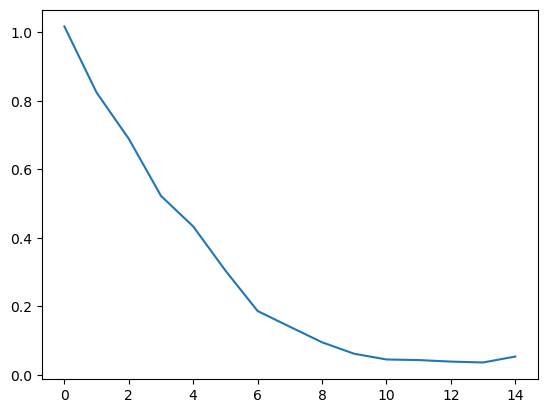

In [61]:
import matplotlib.pyplot as plt 
# loss_history=[loss.detach().numpy() for loss in loss_history]
loss_history=[float(item) for item in loss_history]
loss_history
plt.plot(np.arange(len(loss_history)), loss_history)
plt.show()

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(32, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(input, target)

# Example of target with class probabilities
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print(input)
print(target)
output = loss(input, target)

tensor([[-1.3271, -0.6992, -0.6135, -0.5116,  1.3618],
        [ 0.9106,  0.7923,  1.3120, -0.3339, -0.8360],
        [ 0.8367,  0.6636,  0.4023,  0.3431,  1.3383]], requires_grad=True) tensor([2, 2, 1])


In [ ]:
rnn = nn.LSTM(2, 5, 3)
input = torch.randn(2, 5, 3)
output, (hn, cn) = rnn(input)
output


tensor([[[-0.0690, -0.1981,  0.0882,  0.0168,  0.1063],
         [-0.0700, -0.1991,  0.0864,  0.0170,  0.1076],
         [-0.0684, -0.1978,  0.0885,  0.0155,  0.1068],
         [-0.0685, -0.1983,  0.0898,  0.0200,  0.1058],
         [-0.0686, -0.1976,  0.0888,  0.0157,  0.1065]],

        [[-0.0860, -0.2672,  0.0769,  0.0436,  0.1575],
         [-0.0899, -0.2674,  0.0725,  0.0408,  0.1594],
         [-0.0910, -0.2668,  0.0725,  0.0391,  0.1605],
         [-0.0886, -0.2669,  0.0772,  0.0452,  0.1575],
         [-0.0862, -0.2662,  0.0790,  0.0427,  0.1570]]],
       grad_fn=<MkldnnRnnLayerBackward0>)

In [ ]:
x = torch.randn(4, 4)
x

tensor([[ 1.6558, -0.2022, -1.3979,  0.6183],
        [ 0.5952,  0.8823,  0.4729, -0.2189],
        [ 0.4236,  0.0769, -0.5062,  0.0403],
        [ 2.0873,  0.7553, -1.0960, -0.2279]])

In [ ]:
x.view(16)

tensor([ 1.6558, -0.2022, -1.3979,  0.6183,  0.5952,  0.8823,  0.4729, -0.2189,
         0.4236,  0.0769, -0.5062,  0.0403,  2.0873,  0.7553, -1.0960, -0.2279])

In [ ]:
x.view(len(x), -1)[:, -1]

tensor([ 0.6183, -0.2189,  0.0403, -0.2279])